In [70]:
import xarray as xr
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
import matplotlib.patches as Patch
from matplotlib.ticker import MaxNLocator, FuncFormatter

import tools.config as config
from tools.helper_plot import set_plot_style

def draw_fit_line_ax(ax, df, color='black', title_name='', order=2, ci=95):
    """在指定ax上画拟合线，y轴自动"""
    scatter_kws = dict(s=18)
    line_kws = dict(linewidth=2)
    if isinstance(df, pd.Series):
        x = df.index.values
        y = df.values
        y_colname = df.name or "value"
    else:
        x = df.index.values
        y_colname = df.columns[0]
        y = df.iloc[:, 0].values
    df_plot = pd.DataFrame({"x": x, "y": y})
    sns.regplot(
        data=df_plot,
        x="x",
        y="y",
        order=order,
        ci=ci,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
        color=color,
        ax=ax
    )
    ax.set_title(title_name, pad=6)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.2)

task_name = config.TASK_NAME
# task_name = '20250922_Paper2_Results_HPC_test'
input_dir = f'../../../output/{task_name }/carbon_price/1_draw_data'
output_dir = f"../../../output/{task_name }/carbon_price/3_Paper_figure"
carbon_price_da = xr.open_dataarray(f"{input_dir}/xr_carbon_price.nc")
bio_price_da = xr.open_dataarray(f"{input_dir}/xr_bio_price.nc")

In [71]:
df1 = pd.concat([carbon_price_da.to_pandas().T.iloc[:, :2],bio_price_da.to_pandas().T.iloc[:, 2:12]], axis=1, join='inner')
df1 = df1[df1.index >= config.START_YEAR]
df2 = carbon_price_da.to_pandas().T.iloc[:, 12:]
df2 = df2[df2.index >= config.START_YEAR]
color = 'green'

In [88]:
set_plot_style(20)

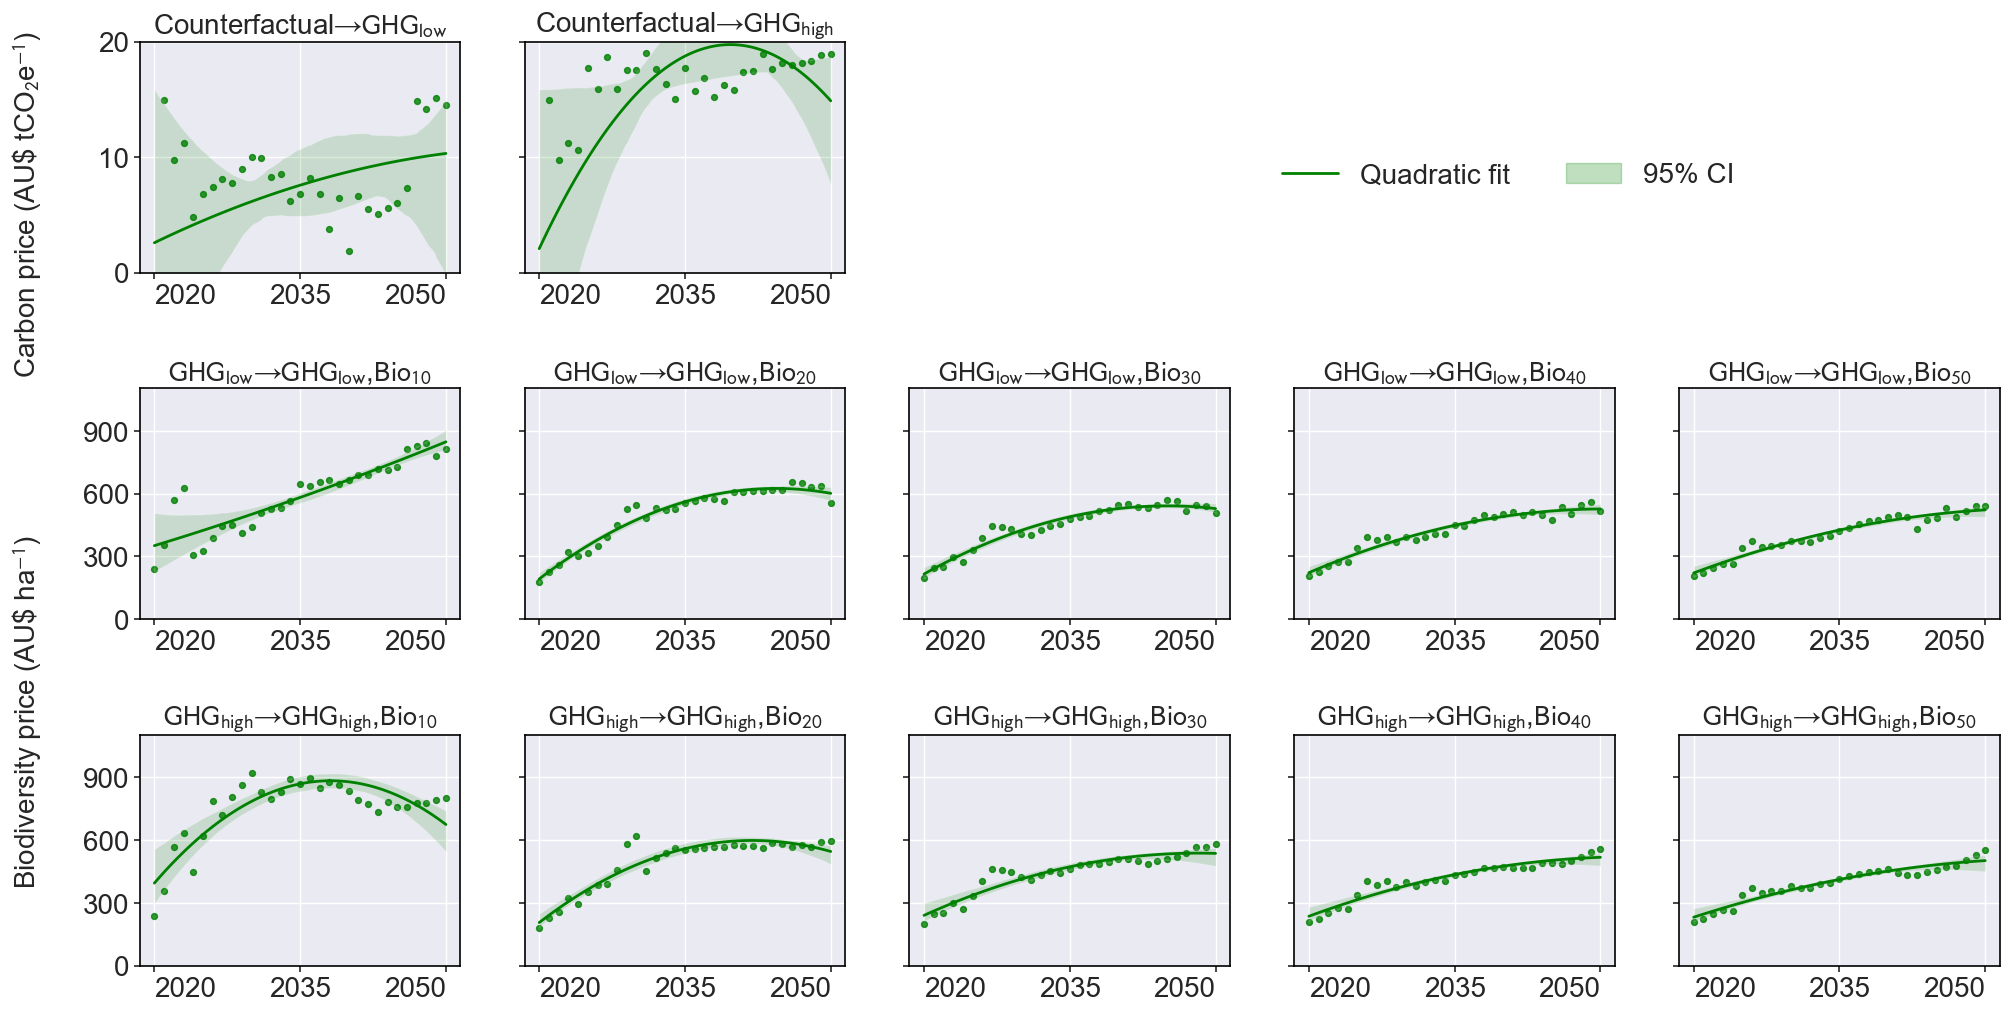

In [89]:


fig = plt.figure(figsize=(24, 12))
color = 'green'
gs = gridspec.GridSpec(3, 5, figure=fig, hspace=0.5, wspace=0.2)

# ------ Carbon部分y轴范围（只用前两列，从0开始） ------
carbon_y = np.concatenate([df1.iloc[:, i].values for i in range(2)])
carbon_ymax = np.nanmax(carbon_y)
# carbon_ylim = (0, carbon_ymax)  # 加10%空间
carbon_ylim = (0,20)

# ------ Bio部分y轴范围（只用后10列，从0开始） ------
bio_y = np.concatenate([df1.iloc[:, i+2].values for i in range(10)])
bio_ymax = np.nanmax(bio_y)
bio_ylim = (0, bio_ymax * 1.2)  # 加10%空间

# ------ x轴刻度（所有数据统一） ------
x_data = df1.index
x_min, x_max = x_data.min(), x_data.max()
x_middle = x_data[int(len(x_data) // 2)]
tick_positions = [x_min, x_middle, x_max]

def int_fmt(x, pos):
    return f"{int(x)}"
int_formatter = FuncFormatter(int_fmt)

# ------ Carbon图（第一行前两个） ------
ax_carbon_list = []
for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    df_input = df1.iloc[:, i].to_frame()
    draw_fit_line_ax(ax, df_input, color=color, title_name=config.PRICE_TITLE_MAP.get(df1.columns[i]))
    ax.set_ylim(*carbon_ylim)
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
    ax.set_yticks([0, 10, 20])
    ax.yaxis.set_major_formatter(int_formatter)
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x')
    x_labels = ax.get_xticklabels()
    if len(x_labels) >= 3:
        x_labels[0].set_horizontalalignment('left')
        x_labels[-1].set_horizontalalignment('right')
    if i != 0:
        ax.tick_params(axis='y', labelleft=False)
    ax_carbon_list.append(ax)

# ------ 图例区 ------
legend_ax = fig.add_subplot(gs[0, 2:])
legend_ax.axis('off')

# ------ Bio图（后两行） ------
ax_bio_list = []
for i in range(10):
    row, col = i // 5 + 1, i % 5
    ax = fig.add_subplot(gs[row, col])
    df_input = df1.iloc[:, i+2].to_frame()
    draw_fit_line_ax(ax, df_input, color=color, title_name=config.PRICE_TITLE_MAP.get(df1.columns[i+2]))
    ax.set_ylim(*bio_ylim)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    ax.yaxis.set_major_formatter(int_formatter)
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x')
    x_labels = ax.get_xticklabels()
    if len(x_labels) >= 3:
        x_labels[0].set_horizontalalignment('left')
        x_labels[-1].set_horizontalalignment('right')
    if col != 0:
        ax.tick_params(axis='y', labelleft=False)
    ax_bio_list.append(ax)

# ------ Y轴标签 ------
ax_carbon_list[0].set_ylabel(r"Carbon price (AU\$ tCO$_2$e$^{-1}$)")
ax_bio_list[0].set_ylabel(r"Biodiversity price (AU\$ ha$^{-1}$)")
ax_carbon_list[0].yaxis.set_label_coords(-0.3, 0.3)
ax_bio_list[0].yaxis.set_label_coords(-0.3, -0.4)

# ------ 图例 ------
line_handle = mlines.Line2D([], [], color=color, linewidth=2, label="Quadratic fit")
shade_handle = Patch.Patch(color=color, alpha=0.25, label="95% CI")
leg = fig.legend(
    handles=[line_handle, shade_handle],
    bbox_to_anchor=(0.8, 0.8),
    ncol=2
)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

plt.show()

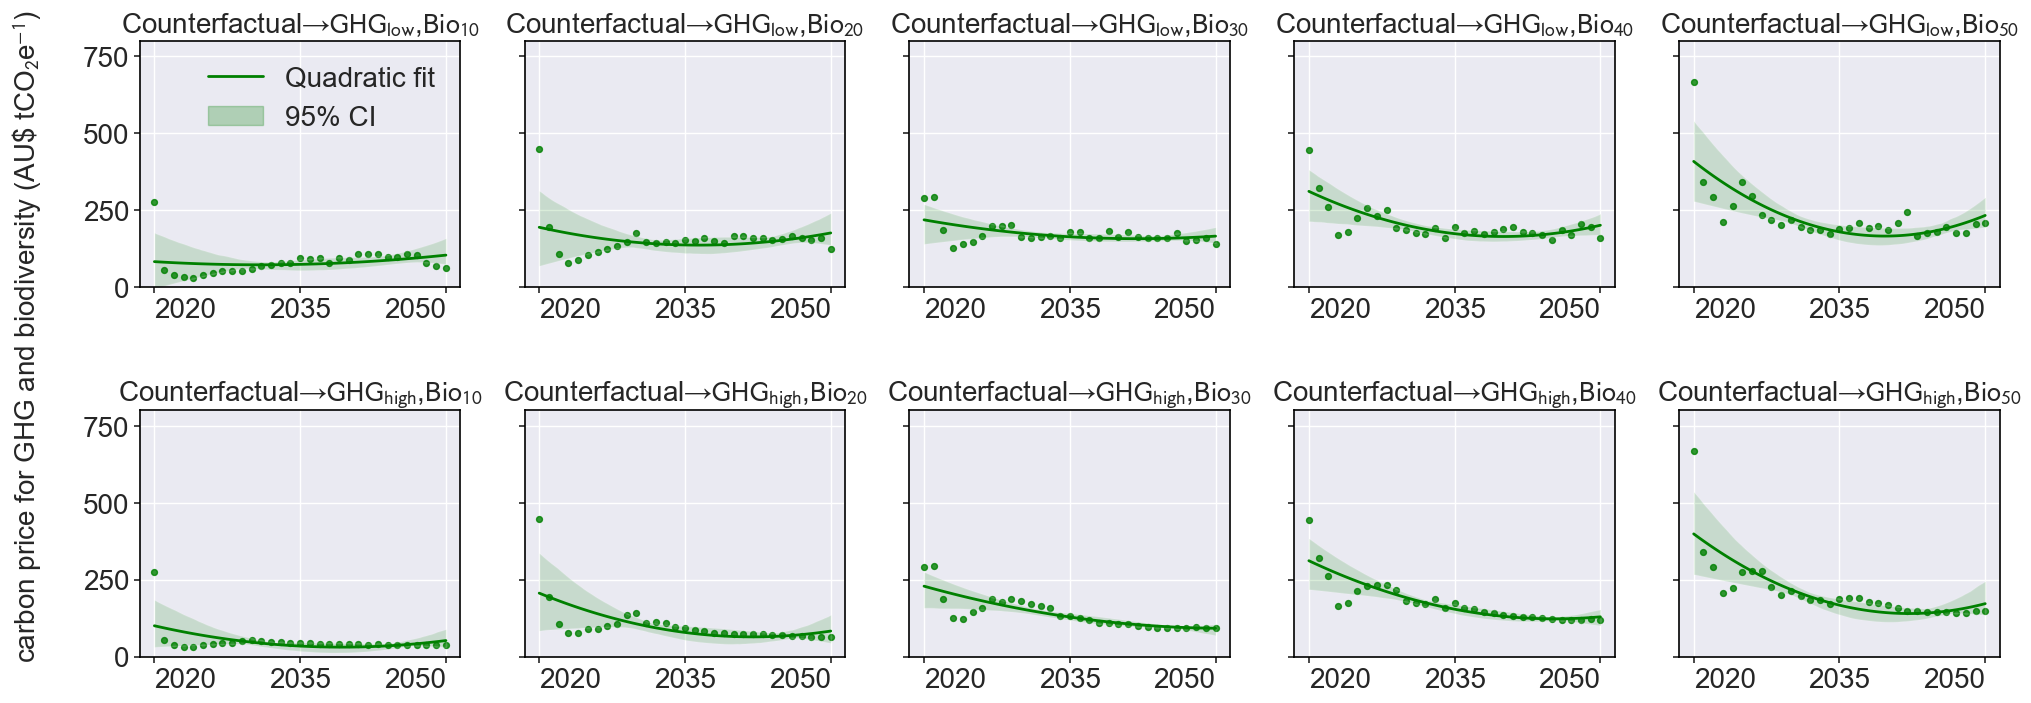

In [90]:
fig = plt.figure(figsize=(24, 8))
color = 'green'
gs = gridspec.GridSpec(2, 5, figure=fig, hspace=0.5, wspace=0.2)

# ------ Bio部分y轴范围（df2全部10列，从0开始） ------
bio_y = np.concatenate([df2.iloc[:, i].values for i in range(10)])
bio_ymax = np.nanmax(bio_y)
bio_ylim = (0, bio_ymax * 1.2)  # 加20%空间

# ------ x轴刻度（所有数据统一） ------
x_data = df2.index
x_min, x_max = x_data.min(), x_data.max()
x_middle = x_data[int(len(x_data) // 2)]
tick_positions = [x_min, x_middle, x_max]

def int_fmt(x, pos):
    return f"{int(x)}"
int_formatter = FuncFormatter(int_fmt)

# ------ Bio图（两行共10张，分别对应df2的10列） ------
ax_bio_list = []
for i in range(10):
    row, col = i // 5, i % 5
    ax = fig.add_subplot(gs[row, col])
    df_input = df2.iloc[:, i].to_frame()
    draw_fit_line_ax(ax, df_input, color=color, title_name=config.PRICE_TITLE_MAP.get(df2.columns[i]))
    ax.set_ylim(*bio_ylim)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    ax.yaxis.set_major_formatter(int_formatter)
    ax.set_xticks(tick_positions)
    ax.tick_params(axis='x')
    x_labels = ax.get_xticklabels()
    if len(x_labels) >= 3:
        x_labels[0].set_horizontalalignment('left')
        x_labels[-1].set_horizontalalignment('right')
    if col != 0:
        ax.tick_params(axis='y', labelleft=False)
    ax_bio_list.append(ax)

# ------ Y轴标签 ------
ax_bio_list[0].set_ylabel(r"carbon price for GHG and biodiversity (AU\$ tCO$_2$e$^{-1}$)")
ax_bio_list[0].yaxis.set_label_coords(-0.3, -0.2)

# ------ 图例 ------
line_handle = mlines.Line2D([], [], color=color, linewidth=2, label="Quadratic fit")
shade_handle = Patch.Patch(color=color, alpha=0.25, label="95% CI")
leg = ax_bio_list[0].legend(
    handles=[line_handle, shade_handle],
    loc='best',
    ncol=1,
    frameon=False
)

plt.show()



In [91]:
df1

scenario,carbon_low,carbon_high,carbon_low_bio_10,carbon_low_bio_20,carbon_low_bio_30,carbon_low_bio_40,carbon_low_bio_50,carbon_high_bio_10,carbon_high_bio_20,carbon_high_bio_30,carbon_high_bio_40,carbon_high_bio_50
Year,,,,,,,,,,,,
2020,-29.191826,-29.191826,238.707184,179.393417,196.691406,207.385681,206.236984,238.707184,179.393417,196.691406,207.385681,206.236984
2021,14.967391,14.967391,355.203827,226.814957,244.999832,223.926956,222.698227,355.203827,226.814957,244.999832,223.926956,222.698227
2022,9.710665,9.710665,566.977966,258.354340,250.855179,252.041565,245.535706,566.977966,258.354340,250.855179,252.041565,245.535706
2023,11.252813,11.194527,628.421814,321.026672,296.717896,272.380493,263.940491,634.954163,323.421204,298.141510,273.272247,263.988098
2024,4.828979,10.618838,304.579803,300.612701,272.002533,271.194397,263.580292,447.352600,295.390045,271.076263,270.315765,263.121307
2025,6.787834,17.744425,327.480377,316.955719,330.185089,339.265289,338.656097,617.690735,352.276703,330.605316,339.037933,339.673248
2026,7.399036,15.929976,389.811493,347.694977,386.007782,392.924774,372.196533,787.501282,384.863647,406.059570,404.114227,372.302734
2027,8.110173,18.632355,445.104889,390.485504,445.877472,378.991699,346.099823,720.815735,390.659424,460.012146,384.494659,347.932251
2028,7.781410,15.924662,447.807739,451.624146,440.010345,393.056580,349.478912,808.106140,456.907593,455.235352,402.868286,355.231964


In [92]:
df2

scenario,Counterfactual_carbon_low_bio_10,Counterfactual_carbon_low_bio_20,Counterfactual_carbon_low_bio_30,Counterfactual_carbon_low_bio_40,Counterfactual_carbon_low_bio_50,Counterfactual_carbon_high_bio_10,Counterfactual_carbon_high_bio_20,Counterfactual_carbon_high_bio_30,Counterfactual_carbon_high_bio_40,Counterfactual_carbon_high_bio_50
Year,,,,,,,,,,
2020,275.887787,448.159271,290.276978,445.567688,667.549194,275.887787,448.159271,290.276978,445.567688,667.549194
2021,55.066093,194.523911,293.235870,320.345551,339.853516,55.066093,194.523911,293.235870,320.345551,339.853516
2022,38.687286,106.640366,186.118729,260.641541,292.372620,38.687286,106.640366,186.118729,260.641541,292.372620
2023,31.007399,78.827660,127.297829,168.202347,209.643707,30.882496,78.046921,125.667450,165.611191,205.957977
2024,28.893377,88.204613,139.075134,177.973694,262.403015,30.940414,75.971619,120.643280,173.517731,222.734451
2025,37.388237,105.602409,146.446823,223.009750,339.921875,37.433773,88.934761,144.347015,211.713989,276.491333
2026,45.024246,112.249329,165.144165,255.902954,295.278381,40.616070,89.063263,158.803116,228.196121,276.919373
2027,53.230614,124.976768,196.634842,230.753387,234.020554,44.727226,98.550659,188.354691,233.235001,278.644592
2028,50.421818,132.419769,196.818237,251.086563,216.842148,44.123344,105.835327,178.563385,233.178009,226.122543
